
### Introduction

This is the third post in my series on transforming data into alpha.  If you haven't yet see the [data management](data_management.html) and [guide to feature engineering](feature_engineering.html), please take a minute to read those first...    

This post is going to delve into the mechanics of _feature selection_ to help choose between the many variations of features created in the feature engineering stage.   If you'd like to replicate and experiment with the below code, _you can download the source notebook for this post by right-clicking on the below button and choosing "save link as"_ 

<a style="text-align: center;" href="https://github.com/convergenceIM/alpha-scientist/blob/master/content/03_Feature_Selection.ipynb"><img src="images/button_ipynb-notebook.png" title="download ipynb" /></a>

By design, many of the features you've created will be very similar to each other (aka "collinear") because you've derived them from the same underlying dataset.  If we were to keep many highly collinear features in our dataset used to train models, it would likely cause the model to "learn" some very funky and dangerous patterns.  I will discuss this in greater depth in a future post.  

The goal of feature selection is to reduce our _possible_ features into _the best_ set of features to learn from data.  This will lead to models which _generalize_ better (i.e., work well on data they haven't seen).  They will also be much more interpretable.  

### Philosophy

In feature selection, we strive to meet two goals:
1. __Strength__:  Choose the features with the strongest, most persistent relationships to the target outcome variable.  The reasons for this are obvious.
2. __Orthogonality__:  Minimize the amount of overlap or collinearity in your selected features.  The importance of orthogonality (non-overlap) of features is much greater than you might guess.  

I am biased towards making feature selection a relatively mechanical process.  The "art" should mainly be encapsulated within the prior step (feature engineering) and the subsequent step (modeling).  

Feature selection should, in my view, follow a heuristic and can be encoded into an algorithm if desired.  For purposes of this tutorial, I'll keep things relatively manual.   

### Preparing the data
Let's dive in.  I will begin by loading prices and creating _outcomes_ `DataFrame` as done in the [post on data management](data_management.html).  

In [1]:
## Replace this section of imports with your preferred
## data download/access interface.  This calls a 
## proprietary set of methods (ie they won't work for you)

from IPython.core.display import Image

import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline


def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO','AMZN','YHOO','MSFT'],data_source='quandl',begin_date='2012-01-01',end_date=None)

print(prices.sort_index().tail())

                      open      high      low    close      volume
date       symbol                                                 
2018-03-26 MSFT      90.61    94.000    90.40    93.78  55031149.0
2018-03-27 AAPL     173.68   175.150   166.92   168.34  38962839.0
           AMZN    1572.40  1575.960  1482.32  1497.05   6793279.0
           CSCO      44.49    44.520    42.24    42.68  30088447.0
           MSFT      94.94    95.139    88.51    89.47  53704562.0


In [13]:
outcomes = pd.DataFrame(index=prices.index)
# next day's opening change
outcomes['close_1'] = prices.groupby(level='symbol').close.pct_change(-1) # next day's returns
outcomes['close_5'] = prices.groupby(level='symbol').close.pct_change(-5) # next week's returns
outcomes['close_10'] = prices.groupby(level='symbol').close.pct_change(-10) # next two weeks' returns
outcomes['close_20'] = prices.groupby(level='symbol').close.pct_change(-20) # next month's (approx) returns

print(outcomes.tail())

                    close_1  close_5  close_10  close_20
date       symbol                                       
2018-03-26 MSFT    0.048173      NaN       NaN       NaN
2018-03-27 AAPL         NaN      NaN       NaN       NaN
           AMZN         NaN      NaN       NaN       NaN
           CSCO         NaN      NaN       NaN       NaN
           MSFT         NaN      NaN       NaN       NaN


However, unlike the prior tutorials, we're going to engineer some features which are constructed to contain a relationship to the outcomes along with quite a bit of random noise.  Clearly, this is not something we'd do in real usage but will help to demonstrate the concept more clearly.  

<img src="https://i.pinimg.com/736x/cf/27/e3/cf27e3d83d8159e6d950408c4e6a3eb4--statistics-humor-data.jpg" width="400">

Assume we have a target variable called `outcome` which can be (partially) predicted with three factors, `factor_1`, `factor_2` and `factor_3`.  There's also an unpredictble noise component.  

We'll use `numpy.random` to graft dummy values mapped onto the indices of real price data.   

In [14]:
num_obs = prices.close.count()
factor_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_3 = pd.Series(np.random.randn(num_obs),index=prices.index)
outcome = 1.*factor_1 + 2.*factor_2 + 3.*factor_3 + 5.*np.random.randn(num_obs)
outcome.name = 'outcome'
print(outcome.tail())


date        symbol
2018-03-26  MSFT     -4.778483
2018-03-27  AAPL      5.043095
            AMZN     -0.849679
            CSCO     -3.225605
            MSFT      0.731300
Name: outcome, dtype: float64


Now, we will engineer several variations on features which each contain some information about the three factors, plus a few which contain some interaction effects, and some which do not contain any useful data.  

Note that we are, again, "cheating" here for illustration purposes. 

In [15]:
features = pd.DataFrame(index=outcome.index)
features['f11'] = 0.2*factor_1 + 0.8*np.random.randn(num_obs)
features['f12'] = 0.4*factor_1 + 0.6*np.random.randn(num_obs)
features['f13'] = 0.6*factor_1 + 0.4*np.random.randn(num_obs)

features['f21'] = 0.2*factor_2 + 0.8*np.random.randn(num_obs)
features['f22'] = 0.4*factor_2 + 0.8*np.random.randn(num_obs)
features['f23'] = 0.6*factor_2 + 0.4*np.random.randn(num_obs)

features['f31'] = 0.2*factor_3 + 0.8*np.random.randn(num_obs)
features['f32'] = 0.4*factor_3 + 0.6*np.random.randn(num_obs)
features['f33'] = 0.6*factor_3 + 0.4*np.random.randn(num_obs)

features['f41'] = 0.2*factor_1+0.2*factor_2 + 0.6*np.random.randn(num_obs)
features['f42'] = 0.2*factor_2+0.2*factor_3 + 0.6*np.random.randn(num_obs)
features['f43'] = 0.2*factor_3+0.2*factor_1 + 0.6*np.random.randn(num_obs)

features['f51'] = np.random.randn(num_obs)
features['f52'] = np.random.randn(num_obs)
features['f53'] = np.random.randn(num_obs)

print(features.tail())


                        f11       f12       f13       f21       f22       f23  \
date       symbol                                                               
2018-03-26 MSFT    0.258367  0.487607  0.847555 -0.848692  0.474134 -0.224899   
2018-03-27 AAPL   -0.785901  0.012815  0.330706 -0.440164 -0.473384 -1.348051   
           AMZN    0.123671 -0.672885 -0.056941  0.005918 -0.399555  1.081308   
           CSCO   -0.154109 -0.800900 -0.154524  0.575503  0.041211  0.086861   
           MSFT    0.354780 -0.614682  1.141737 -0.612581  0.599909  0.487664   

                        f31       f32       f33       f41       f42       f43  \
date       symbol                                                               
2018-03-26 MSFT   -0.395561 -1.020660  0.717344  0.636148  0.622086  0.118537   
2018-03-27 AAPL   -0.101715  0.365675 -0.376853 -0.111023 -1.505077  0.266620   
           AMZN    1.059323 -0.235177 -1.304285  0.491856  0.404354  0.006744   
           CSCO   -0.504884

Before evaluating the features for predictive strength and orthogonality, we'll do a quick data preparation stage. It is sometimes vital to "standardize" or "normalize" data so that we get fair comparisons between features of differing scale.  Strictly speaking, since all of the doctored outcome and feature data is already drawn from normal distribution (using the numpy function `random.rnorm()`) we don't really need this step, but good practice to include.  

Here, I'll use the scikit-learn `StandardScaler()` method and some pandas magic to transform the data.  

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler,Normalizer


#f = features.dropna() #optional - to compare apples to apples

# standardize or normalize data 
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features.dropna()) 
print (features_scaled.shape)
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.tail()

# standardize outcome as well 
outcome_df = outcome.to_frame()
outcome_scaled = std_scaler.fit_transform(outcome_df.dropna()) 
outcome_scaled = pd.DataFrame(outcome_scaled,index=outcome_df.dropna().index)
outcome_scaled.columns = outcome_df.columns
print(outcome_scaled.tail())


(7639, 15)
                    outcome
date       symbol          
2018-03-26 MSFT   -0.774059
2018-03-27 AAPL    0.808197
           AMZN   -0.141129
           CSCO   -0.523890
           MSFT    0.113567


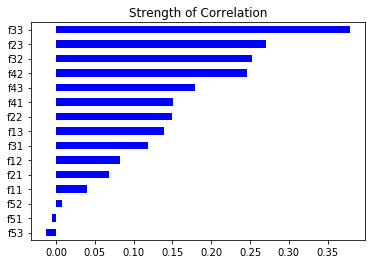

In [17]:
corr = df.corrwith(outcome)
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

Pretend for a minute that we don't know which features are going to be stronger and weaker, and which are going to tend to cluster together.  We've got an idea that there are some quite strong features, some weaker, and some useless.  

While correlation is not the perfect metric, it gives us a reasonable sense of __strength__ of each feature's historical relationship to the outcome variable. 

However, it says nothing about __orthogonality__.  To get an idea about this, we'll take advantage of the very handy seaborn `clustermap` chart type which plots a heatmap representation of a covariance matrix and runs a hierarchical clustering algorithm to group together the most closely related features. 

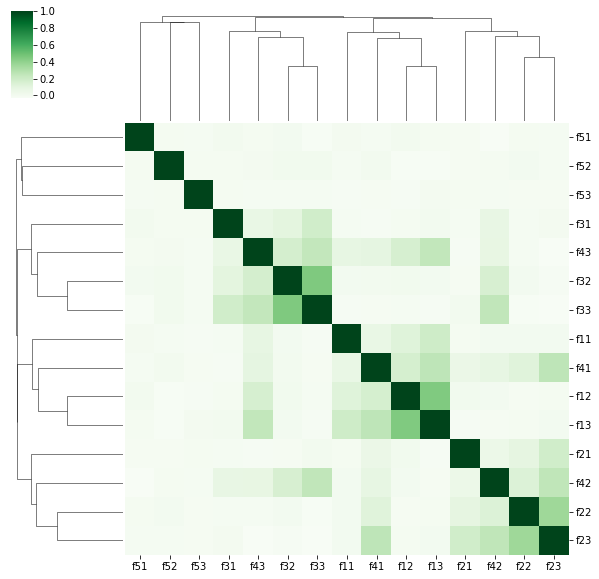

In [18]:
corr_matrix = df.corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(10,10),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns



The algorithm has done a good job of finding the groupings of features.  Of course, the diagonal of dark green represents each feature being perfectly correlated with itself, but we also see certain clusters of features which are similar to one another.  

The cluster in the upper left captures `factor_1` (including some of the interaction effects).  `factor_3` is fairly well isolated in the lower right corner, and in the middle we can see `factor_2` as well as some of the noise features. 

Let's next focus in only on those features with correlations of greater than 0.1 to exclude the noise and weak features.

In [19]:
corr

f11    0.039961
f12    0.082385
f13    0.138850
f21    0.067897
f22    0.149363
f23    0.270455
f31    0.118701
f32    0.252563
f33    0.379145
f41    0.150352
f42    0.246672
f43    0.179105
f51   -0.005206
f52    0.007507
f53   -0.013350
dtype: float64

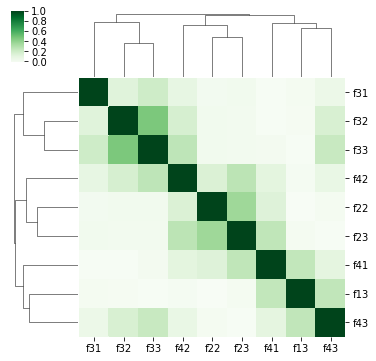

Correlation Strength:
f33    0.400933
f23    0.269641
f32    0.261031
f42    0.234578
f43    0.159896
f22    0.139023
f41    0.133366
f31    0.125272
f13    0.121643
dtype: float64


In [8]:
correlated_features = corr[corr>0.1].index.tolist()
corr_matrix = df[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength:")
print(corr[corr>0.1].sort_values(ascending=False))

Ah, now the clusters look a bit sharper.  We'll follow a simple heuristic to manually select the features.   

__Step 1:__ Take the most strongly correlated feature (f33) and add it to our list of selected features.
__Step 2:__ Take the second correlated feature (f23) and check to see if it's closely correlated (neighboring in the clustermap) to any features already chosen.  If no, add to the list.  If yes, discard.
__Step 3:__ Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.  

_Those interested could encode this heuristic into an algorithm without too much difficulty._

Following this heuristic, I get the below features:

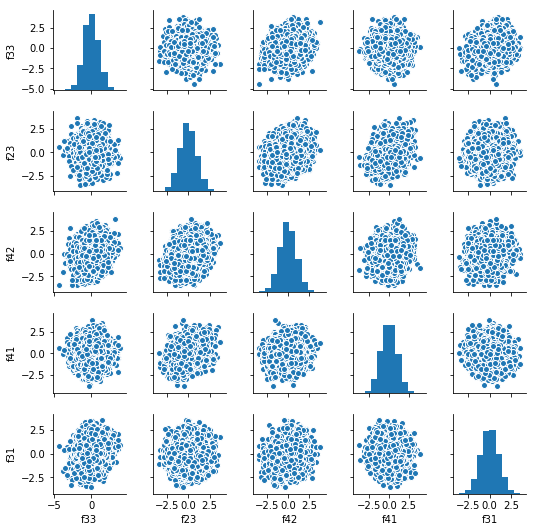

In [9]:
selected_features = ['f33','f23','f42','f41','f31']
import seaborn as sns
sns.pairplot(df[selected_features],size=1.5)

Note that this list of features is not simply the highest correlated features.  Let's run the clustermap one more time to see if we've missed any major clusters.  

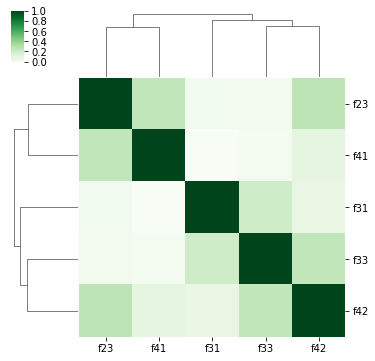

In [10]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns


Looks generally pretty good.  There is some residual covariance between features, so we haven't achieved orthogonal nirvana, but we're pretty close.  

Thus far, we've only used a simple correlation statistic across the full time period.  This is a good place to start but, in my opinion, is a dangerous place to stop.  Financial time series data suffers from non-stationarity and regime change, so a relationship which _on average_ has existed may have been wildly unstable over time.  

To check, we'll plot the rolling correlation of these selected features.

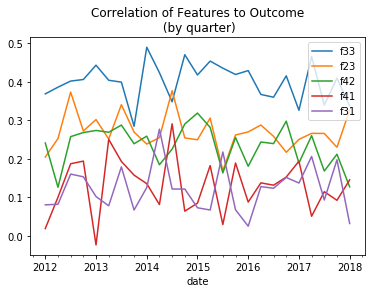

In [11]:
tmp = df[selected_features].join(outcome_scaled).reset_index().set_index('date')
tmp.dropna().resample('Q').apply(lambda x: x.corr()).iloc[:,-1].unstack()\
.iloc[:,:-1].plot(title='Correlation of Features to Outcome\n (by quarter)')
# shows time stability

As expected, since the data wasn't modeled with any non-stationarity, our features all appear to be robust over time.  This gives increased confidence that the relationship we've found is likely to persist.  

### Summary



This installment of the tutorial series has walked through a systematic approach for selecting a subset of features from a universe of many overlapping (collinear) features.  At this point, we're ready to model! 

In the [next post](), I'll walk through an approach for training models in a "walk forward" basis - highly useful when working with ordered (e.g., time series) datasets.  

### One last thing...

If you've found this post useful, please follow [@data2alpha](https://twitter.com/data2alpha) on twitter and forward to a friend or colleague who may also find this topic interesting.

Finally, take a minute to leave a comment below - either to discuss this post or to offer an idea for future posts.  Thanks for reading!